In [1]:
import numpy as np
import matplotlib.pyplot as plt


class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        self.W = np.random.normal(loc=0,scale=1, size=(hidden_size, input_size+ 1)) # input to hidden
        self.v = np.random.normal(loc=0,scale=1, size=(output_size, hidden_size+ 1 )) # hidden to output
        self.dw = np.zeros(self.W.shape)
        self.dv = np.zeros(self.v.shape)

    def transfer_function(self, x):
        return 2 / (1 + np.exp(-x)) - 1

    def TF_derivative(self, x):
        derivative = self.transfer_function(x)
        return (1 + derivative) * (1 - derivative) / 2

    def forward(self, X):
        X = np.vstack((X, np.ones((1, X.shape[1])))) # (D+1)*N
        self.hin = np.dot(self.W , X)
        hout = self.transfer_function(self.hin)# H*N

        self.hout = np.vstack((hout, np.ones((1,hout.shape[1])))) # (H+1)*N
        self.oin = np.dot(self.v, self.hout)# O*N
        self.out = self.transfer_function(self.oin) # O*N
        return self.out
    

    def backward(self, X, T, output):
        #m = X.shape[1]
        X = np.vstack((X, np.ones((1, X.shape[1])))) # (D+1)*N
        m = 1
        delta_out = (output - T) * self.TF_derivative(self.oin)# O*N
        dV = np.dot(delta_out, self.hout.T) / m

        delta_hidden = np.dot(self.v[:, :-1].T,delta_out) * self.TF_derivative(self.hin)# H*N
        dW = np.dot(delta_hidden, X.T) / m
        self.dW_current, self.dV_current = dW, dV

    def weight_update(self, learning_rate,alpha=0.9):
        self.dv = alpha * self.dv - (1 - alpha) * self.dV_current
        self.dw = alpha * self.dw - (1 - alpha) * self.dW_current
        self.W += learning_rate * self.dw
        self.v += learning_rate * self.dv

    def mse(self, output, target):
        return np.mean((output - target) ** 2)
    
    def error_rate_binary(self, output, target):
        return np.sum(output*target<0)/output.shape[1]
        
class RBFNN:
    def __init__(self, node_number, sigma=1.0, eta=0.01, random_state= False):
        self.node_number = node_number
        self.sigma = sigma
        self.eta = eta  
        self.node_positions = None
        self.weights = None
        self.kernel_matrix = None
        self.training_errors = []
        self.random_state = random_state
    def get_node_positions(self, X):
        if self.random_state:
            self.node_positions = np.random.uniform(0, 2*np.pi, self.node_number)
        else:
            self.node_positions = np.linspace(0, 2*np.pi, self.node_number)

    def RBF_function(self, x, node_position):
        return np.exp(-np.linalg.norm(x - node_position)**2 / (2 * self.sigma**2))

    def get_kernel_matrix(self, X):
        self.get_node_positions(X)
        kernel_matrix = np.zeros((len(X), self.node_number))
        for i in range(len(X)):
            kernel_matrix[i, :] = np.array([self.RBF_function(X[i], node_position) for node_position in self.node_positions])
        return kernel_matrix

    def fit_batch(self, X, Y):
        self.kernel_matrix = self.get_kernel_matrix(X)
        self.weights, _, _, _ = np.linalg.lstsq(self.kernel_matrix, Y, rcond=None)

    def fit_online(self, X, Y, epochs=100):
        self.get_node_positions(X)
        self.weights = np.random.randn(self.node_number)
        self.training_errors = []
        for epoch in range(epochs):

            total_error = 0
            for i in range(len(X)):
                phi_x = np.array([self.RBF_function(X[i], node_position) for node_position in self.node_positions])
                y_pred = np.dot(phi_x, self.weights)
                error = Y[i] - y_pred
                self.weights += self.eta * error * phi_x
                total_error += np.abs(error)
            if (epoch+1) % 10 ==0:
                self.training_errors.append(total_error / len(X))

    def predict(self, X_test):
        kernel_test = self.get_kernel_matrix(X_test)
        return np.dot(kernel_test, self.weights)


RBF sin(2x) MAE: 0.22823
MLP sin(2x) MAE: 0.26317


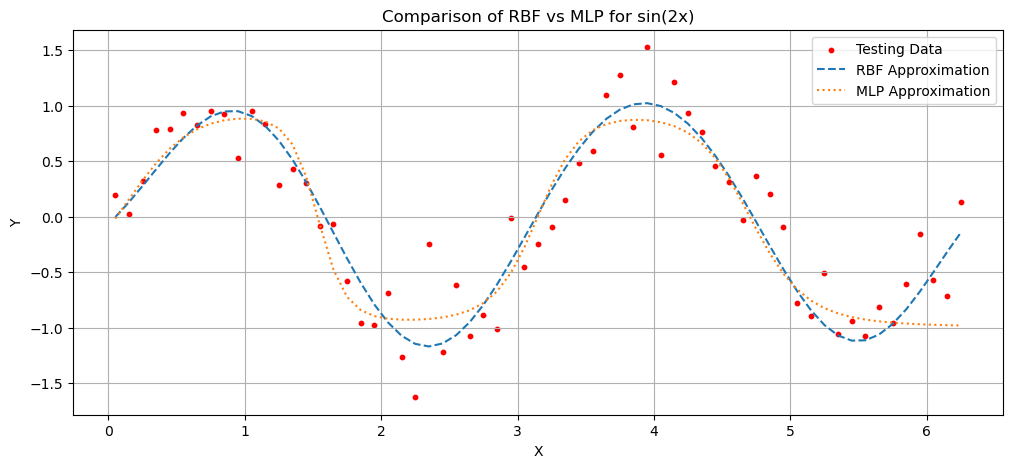

In [3]:
noise_variance = 0.1
X_train = np.arange(0, 2*np.pi, 0.1)
sin_Y_train = np.sin(2 * X_train) + np.random.normal(0, np.sqrt(noise_variance), len(X_train))
square_Y_train = np.sign(np.sin(2 * X_train)) + np.random.normal(0, np.sqrt(noise_variance), len(X_train))

X_test = np.arange(0.05, 2*np.pi, 0.1)
sin_Y_test = np.sin(2 * X_test) + np.random.normal(0, np.sqrt(noise_variance), len(X_test))
square_Y_test = np.sign(np.sin(2 * X_test))+ np.random.normal(0, np.sqrt(noise_variance), len(X_test))

node_number = 10
sigma = 0.7
learning_rate = 0.05
epochs = 1000

# Train RBF for sin(2x)
rbf_sin = RBFNN(node_number, sigma)
rbf_sin.fit_batch(X_train, sin_Y_train)
Y_pred_sin_rbf = rbf_sin.predict(X_test)
error_sin_rbf = np.mean(np.abs(Y_pred_sin_rbf - sin_Y_test))

# Train MLP for sin(2x)
mlp_sin = MLP(1, node_number, 1)
for epoch in range(epochs):
    output = mlp_sin.forward(X_train.reshape(1, -1))
    mlp_sin.backward(X_train.reshape(1, -1), sin_Y_train.reshape(1, -1), output)
    mlp_sin.weight_update(learning_rate)
Y_pred_sin_mlp = mlp_sin.forward(X_test.reshape(1, -1)).flatten()
error_sin_mlp = np.mean(np.abs(Y_pred_sin_mlp - sin_Y_test))


print(f"RBF sin(2x) MAE: {error_sin_rbf:.5f}")
print(f"MLP sin(2x) MAE: {error_sin_mlp:.5f}")

# Plot
plt.figure(figsize=(12, 5))
plt.scatter(X_test, sin_Y_test, color='red', s=10, label="Testing Data")
plt.plot(X_test, Y_pred_sin_rbf, label="RBF Approximation", linestyle='dashed')
plt.plot(X_test, Y_pred_sin_mlp, label="MLP Approximation", linestyle='dotted')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Comparison of RBF vs MLP for sin(2x)")
plt.legend()
plt.grid()
plt.show()